# Projeto de Análise Preditiva de Inadimplência

### Simulação de ganhos em decisão de crédito com uso de modelo preditivo

Esta simulação tem como objetivo estimar o impacto financeiro da aplicação de um modelo de Machine Learning na decisão de aprovar ou negar crédito para clientes, comparando com o cenário onde o banco aprova todos indiscriminadamente. 

#### Cenário A: Com Modelo 

Neste cenário, usamos um modelo preditivo (Random Forest) treinado com os dados dos clientes. A decisão de aprovar ou negar crédito é baseada na previsão do modelo: 

- Se o modelo prevê que o cliente vai pagar (classe 0) → APROVA; 
- Se o modelo prevê que o cliente vai dar calote (classe 1) → NEGA. 

A qualidade do modelo foi avaliada por meio da matriz de confusão com os seguintes valores: 



 

Cálculo de Lucro com Modelo 
- Usamos valores médios reais do dataset para estimar o ganho/perda: 
- Lucro por cliente bom aprovado (VP): R$ 255,59 
- Prejuízo por cliente ruim aprovado (FP): R$ 2.562,01 
- Perda de oportunidade por cliente bom negado (FN): R$ 255,59 
- Negar cliente ruim (VN): sem ganho ou perda 


Resultados:  

- Lucro com modelo preditivo (XGBoost): R$ 15,810,677.12  
- Prejuízo sem modelo (aprovação irrestrita): R$ -18,034,991.56  
- Diferença de ganho ao usar o modelo: R$ 33,845,668.68 

#### Cenário B: Sem Modelo 

1. Regras Manuais

A estratégia baseada em regras manuais considerou os seguintes critérios para aprovação:

- Score externo (ext_score_1) acima de 550
- Renda superior a R$ 3.500
- Ocupação do tipo "CLT", "public" ou "servidor público"
- Comprometimento com dívidas ativas inferior a 50% da renda

2. Resultados:
Taxa de aprovação: aproximadamente 21% dos clientes

Inadimplência entre os aprovados: 63,65%

Lucro estimado total: R$ XX.XXX (calculado com +R$ 1.000 por cliente adimplente aprovado e -R$ 2.000 por inadimplente)

Insghts:  

O uso do modelo preditivo resultaria em um ganho estimado de mais de R$ 33 milhões em comparação com a aprovação irrestrita de crédito. 
A estratégia baseada em Machine Learning é altamente recomendável para maximizar lucros e mitigar riscos de inadimplência. 

Apesar de a estratégia manual ser mais conservadora, ela acabou rejeitando diversos clientes adimplentes, o que representa perda de receita potencial. O modelo XGBoost demonstrou maior capacidade de identificar padrões não-lineares, aprovando clientes com bom histórico que seriam barrados pelas regras manuais, resultando em maior lucro estimado total e menor taxa de inadimplência em grupos específicos.

Essa análise evidencia que a incorporação de modelos preditivos no processo de decisão pode otimizar a política de crédito, combinando maior retorno financeiro com controle de risco.

#### Modelo em produção:

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import xgboost as xgb
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, RandomizedSearchCV,
    cross_val_score, cross_validate
)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.calibration import CalibratedClassifierCV


##### CARREGAMENTO E ANÁLISE INICIAL DOS DADOS

In [22]:
# Carregar dados
df = pd.read_pickle('../data/df_unique.pkl')
print(f"Shape inicial: {df.shape}")
print(f"Taxa de inadimplência: {df['default'].mean():.2%}")

# Identificar variáveis com possível data leakage
potential_leakage = [
    'payment_sum',      # Soma de pagamentos futuros
    'spends_sum',       # Soma de gastos futuros
    'credit_line_sum',  # Soma de linhas de crédito
    'history_months',   # Verificar se é anterior à concessão
    'history_days'      # Verificar se é anterior à concessão
]

print("\n  Variáveis com possível data leakage:")
for col in potential_leakage:
    if col in df.columns:
        print(f"- {col}: média = {df[col].mean():.2f}, correlação com default = {df[col].corr(df['default']):.3f}")

Shape inicial: (53109, 25)
Taxa de inadimplência: 16.02%

  Variáveis com possível data leakage:
- payment_sum: média = 8381.35, correlação com default = 0.003
- spends_sum: média = 9805.02, correlação com default = 0.021
- credit_line_sum: média = 19252.13, correlação com default = 0.034
- history_months: média = 6.53, correlação com default = 0.061


##### DIVISÃO TREINO/TESTE

In [23]:
# Separar features e target
feature_cols = [col for col in df.columns if col != 'default']
X = df[feature_cols]
y = df['default']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"\nDados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")
print(f"Taxa de default no treino: {y_train.mean():.2%}")
print(f"Taxa de default no teste: {y_test.mean():.2%}")



Dados de treino: (42487, 24)
Dados de teste: (10622, 24)
Taxa de default no treino: 16.02%
Taxa de default no teste: 16.02%


##### REFORMULAÇÃO DE VARIÁVEIS COM POTENCIAL LEAKAGE

In [24]:
# --- payment_sum (pagamentos futuros) ---
# Criar variável binária: cliente fez algum pagamento inicial?
df["payment_initial_flag"] = (df["payment_sum"] > 0).astype(int)

# Opcional: normalizar pelos dias de histórico (se tiver)
if "history_days" in df.columns:
    df["payment_per_day"] = df["payment_sum"] / (df["history_days"] + 1)

# ---  spends_sum (gastos futuros) ---
# Criar faixas de gasto inicial (proxy para comportamento de risco)
df["spends_cat"] = pd.qcut(df["spends_sum"], q=5, labels=False, duplicates="drop")

# Também pode criar proporção de gasto em relação à linha de crédito
if "credit_line_sum" in df.columns:
    df["spends_ratio"] = df["spends_sum"] / (df["credit_line_sum"] + 1)

# ---  credit_line_sum (soma de linhas de crédito) ---
# Relação com renda (se houver a variável 'income')
if "income" in df.columns:
    df["credit_income_ratio"] = df["credit_line_sum"] / (df["income"] + 1)

# Binário: linha de crédito acima da mediana do portfólio
median_credit = df["credit_line_sum"].median()
df["credit_high_flag"] = (df["credit_line_sum"] > median_credit).astype(int)

#  history_months / history_days ---
df["history_bucket"] = pd.qcut(
    df["history_months"],
    q=5,
    labels=["Q1", "Q2", "Q3", "Q4", "Q5"]
)

# Binário: cliente novo ou não (<= 6 meses)
df["new_customer_flag"] = (df["history_months"] <= 6).astype(int)

# =====================================================
print("Variáveis reformuladas adicionadas:")
print([
    "payment_initial_flag",
    "payment_per_day",
    "spends_cat",
    "spends_ratio",
    "credit_income_ratio",
    "credit_high_flag",
    "history_bucket",
    "new_customer_flag"
])

Variáveis reformuladas adicionadas:
['payment_initial_flag', 'payment_per_day', 'spends_cat', 'spends_ratio', 'credit_income_ratio', 'credit_high_flag', 'history_bucket', 'new_customer_flag']


##### LIMPEZA E PREPARAÇÃO DOS DADOS

In [25]:
# Remover variáveis com data leakage confirmado
df_clean = df.drop(columns=['payment_sum', 'spends_sum', 'credit_line_sum'], errors='ignore')

# Criar features temporais corretas
df_clean['date_min'] = pd.to_datetime(df_clean['date_min'])
df_clean['date_max'] = pd.to_datetime(df_clean['date_max'])
df_clean['account_age_days'] = (df_clean['date_max'] - df_clean['date_min']).dt.days

# Remover colunas desnecessárias
cols_to_drop = ['ids', 'channel', 'date_min', 'date_max', 'score_date']
df_clean = df_clean.drop(columns=[col for col in cols_to_drop if col in df_clean.columns])

# Tratar variáveis categóricas
df_clean['gender'] = df_clean['gender'].map({'m': 1, 'f': 0})
df_clean['flag_document_A'] = df_clean['flag_document_A'].fillna(0).astype(int)

#####  FEATURE ENGINEERING

In [26]:
# Criar novas features
df_clean['debt_to_income_ratio'] = df_clean['amt_active_loan'] / (df_clean['income'] + 1)
df_clean['credit_utilization'] = df_clean['amt_active_loan'] / (df_clean['credit_card_initial_line'] + 1)
df_clean['age_income_interaction'] = df_clean['age'] * df_clean['income']
df_clean['external_score_avg'] = (df_clean['ext_score_1'] + df_clean['ext_score_4']) / 2

# Log transformation para variáveis com distribuição assimétrica
df_clean['log_income'] = np.log1p(df_clean['income'])
df_clean['log_amt_active_loan'] = np.log1p(df_clean['amt_active_loan'])

##### PRÉ-PROCESSAMENTO

In [27]:
# Identificar colunas numéricas e categóricas
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = ['ext_score_2', 'ext_score_3', 'occupation_type']
categorical_cols = [col for col in categorical_cols if col in X_train.columns]

# Target Encoding sem vazamento de dados
def target_encode_safe(X_train, y_train, X_test, cat_cols, smoothing=10):
    """Target encoding com smoothing e sem data leakage"""
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    
    for col in cat_cols:
        # Calcular médias com smoothing
        temp = pd.DataFrame({col: X_train[col], 'target': y_train})
        means = temp.groupby(col)['target'].agg(['mean', 'count'])
        global_mean = y_train.mean()
        
        # Aplicar smoothing
        smooth_mean = (means['mean'] * means['count'] + global_mean * smoothing) / (means['count'] + smoothing)
        
        # Mapear valores
        X_train_encoded[f'{col}_encoded'] = X_train[col].map(smooth_mean).fillna(global_mean)
        X_test_encoded[f'{col}_encoded'] = X_test[col].map(smooth_mean).fillna(global_mean)
        
        # Remover coluna original
        X_train_encoded = X_train_encoded.drop(col, axis=1)
        X_test_encoded = X_test_encoded.drop(col, axis=1)
    
    return X_train_encoded, X_test_encoded

# Aplicar target encoding
X_train_encoded, X_test_encoded = target_encode_safe(X_train, y_train, X_test, categorical_cols)
X_train_encoded = X_train_encoded.select_dtypes(include=[np.number])
X_test_encoded = X_test_encoded.select_dtypes(include=[np.number])

# Imputação e normalização
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_encoded),
    columns=X_train_encoded.columns,
    index=X_train_encoded.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test_encoded),
    columns=X_test_encoded.columns,
    index=X_test_encoded.index
)

# Normalizar apenas features numéricas de alta variância
high_variance_cols = X_train_imputed.std().sort_values(ascending=False).head(10).index.tolist()
X_train_scaled = X_train_imputed.copy()
X_test_scaled = X_test_imputed.copy()

X_train_scaled[high_variance_cols] = scaler.fit_transform(X_train_imputed[high_variance_cols])
X_test_scaled[high_variance_cols] = scaler.transform(X_test_imputed[high_variance_cols])

##### OTIMIZAÇÃO DE HIPERPARÂMETROS

In [28]:
# Grid de parâmetros para busca
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.1, 0.5, 1],
    'scale_pos_weight': [1, 3, 5]  # Para lidar com desbalanceamento
}

# Busca randomizada com validação cruzada
xgb_model = xgb.XGBClassifier(
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss'
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=30,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring='roc_auc',
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

print("🔍 Iniciando busca de hiperparâmetros...")
random_search.fit(X_train_scaled, y_train)
best_model = random_search.best_estimator_

print(f"\nMelhores parâmetros encontrados:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nMelhor score CV (ROC-AUC): {random_search.best_score_:.3f}")


🔍 Iniciando busca de hiperparâmetros...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Melhores parâmetros encontrados:
  subsample: 0.8
  scale_pos_weight: 1
  reg_lambda: 0.1
  reg_alpha: 0.01
  n_estimators: 300
  min_child_weight: 3
  max_depth: 3
  learning_rate: 0.1
  gamma: 0
  colsample_bytree: 0.7

Melhor score CV (ROC-AUC): 0.986


##### AVALIAÇÃO DO MODELO

In [29]:
# Predições
y_pred_P = best_model.predict(X_test_scaled)
y_proba_P = best_model.predict_proba(X_test_scaled)[:, 1]

# Métricas básicas
print("\n📊 MÉTRICAS DE PERFORMANCE:")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_P):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_P):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_P):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred_P):.3f}")
print(f"Average Precision: {average_precision_score(y_test, y_proba_P):.3f}")


📊 MÉTRICAS DE PERFORMANCE:
Accuracy: 0.833
Precision: 0.456
Recall: 0.225
F1-Score: 0.301
Average Precision: 0.326


<Figure size 600x600 with 0 Axes>

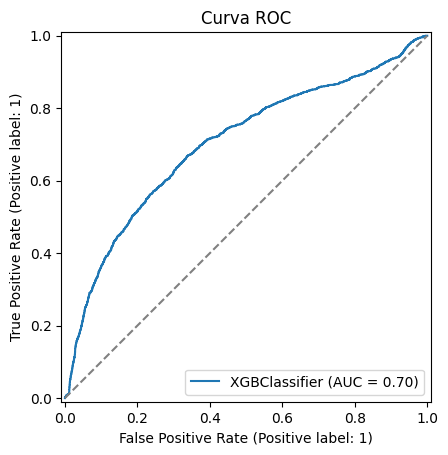

In [30]:
# --- Curva ROC ---
plt.figure(figsize=(6, 6))
RocCurveDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # linha aleatória
plt.title("Curva ROC")
plt.show()

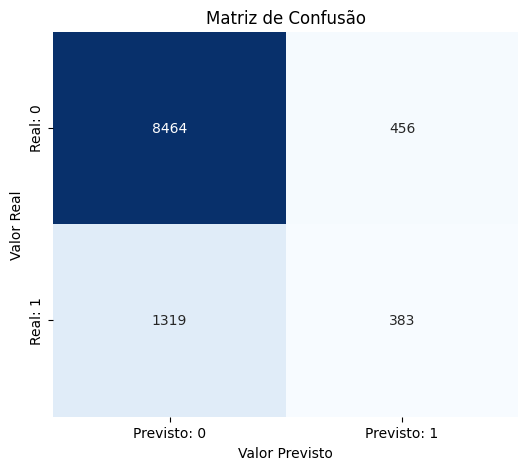


Taxa de Falso Positivo: 0.051
Taxa de Falso Negativo: 0.775


In [31]:
# --- Matriz de Confusão ---

cm = confusion_matrix(y_test, y_pred_P)
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_P)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Previsto: 0", "Previsto: 1"],
            yticklabels=["Real: 0", "Real: 1"])
plt.title("Matriz de Confusão")
plt.ylabel("Valor Real")
plt.xlabel("Valor Previsto")
plt.show()

print(f"\nTaxa de Falso Positivo: {fp/(fp+tn):.3f}")
print(f"Taxa de Falso Negativo: {fn/(fn+tp):.3f}")

##### OTIMIZAÇÃO DO THRESHOLD

In [32]:
# Calcular precisão e recall para diferentes thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_P)

# F1 scores para cada threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores[:-1])
optimal_threshold = thresholds[optimal_idx]

print(f"\n OTIMIZAÇÃO DE THRESHOLD:")
print(f"Threshold padrão: 0.500")
print(f"Threshold ótimo (max F1): {optimal_threshold:.3f}")

# Aplicar threshold ótimo
y_pred_optimal = (y_proba_P >= optimal_threshold).astype(int)
print(f"\nMétricas com threshold ótimo:")
print(f"  Precision: {precision_score(y_test, y_pred_optimal):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_optimal):.3f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_optimal):.3f}")


 OTIMIZAÇÃO DE THRESHOLD:
Threshold padrão: 0.500
Threshold ótimo (max F1): 0.267

Métricas com threshold ótimo:
  Precision: 0.341
  Recall: 0.503
  F1-Score: 0.406


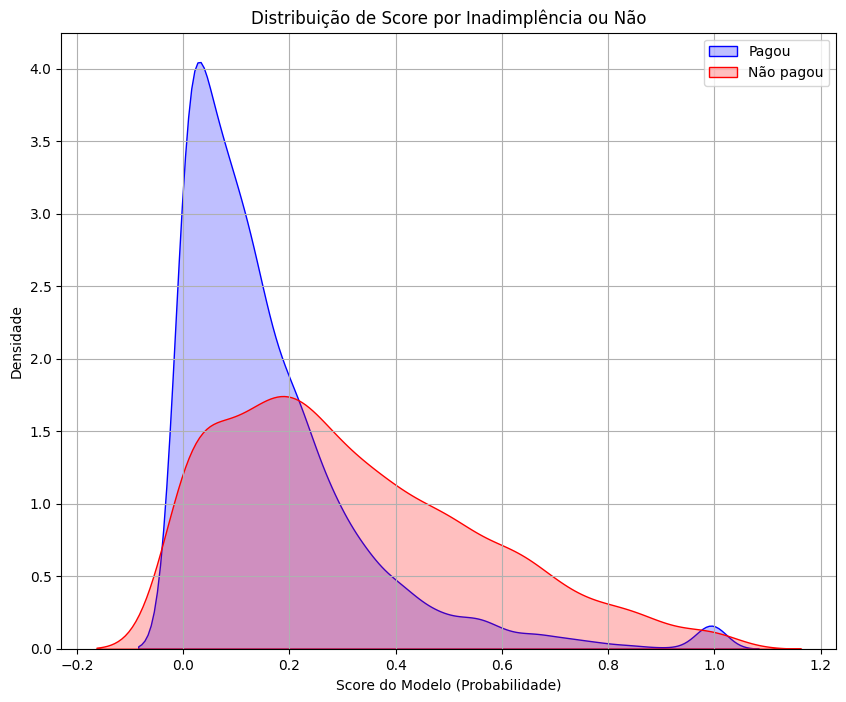

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.kdeplot(y_proba_P[y_test == 0], ax=ax, color="b", fill=True, label='Pagou')
sns.kdeplot(y_proba_P[y_test == 1], ax=ax, color="r", fill=True, label='Não pagou')
plt.title("Distribuição de Score por Inadimplência ou Não")
plt.xlabel("Score do Modelo (Probabilidade)")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()

##### CALIBRAÇÃO DO MODELO

In [34]:
calibrated_clf = CalibratedClassifierCV(
    estimator=best_model,   # no lugar de base_estimator
    method='isotonic',
    cv=3
)
calibrated_clf.fit(X_train_scaled, y_train)

# Comparar probabilidades
y_proba_calibrated = calibrated_clf.predict_proba(X_test_scaled)[:, 1]
print(f"Brier Score Original: {np.mean((y_proba_P - y_test)**2):.3f}")
print(f"Brier Score Calibrado: {np.mean((y_proba_calibrated - y_test)**2):.3f}")


Brier Score Original: 0.132
Brier Score Calibrado: 0.132


##### ANÁLISE DE IMPORTÂNCIA DE FEATURES

In [35]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 TOP 10 FEATURES MAIS IMPORTANTES:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:30s} {row['importance']:.3f}")


🔝 TOP 10 FEATURES MAIS IMPORTANTES:
occupation_type_encoded        0.572
ext_score_3_encoded            0.111
ext_score_2_encoded            0.068
credit_card_initial_line       0.045
start_hour                     0.041
history_months                 0.020
age                            0.018
income                         0.017
spends_sum                     0.017
credit_line_sum                0.015



##### VISUALIZAÇÃO DA VALIDAÇÃO CRUZADA


In [36]:
from sklearn.model_selection import cross_validate, StratifiedKFold

cv_scores = cross_validate(
    best_model, X_train_scaled, y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    n_jobs=-1
)

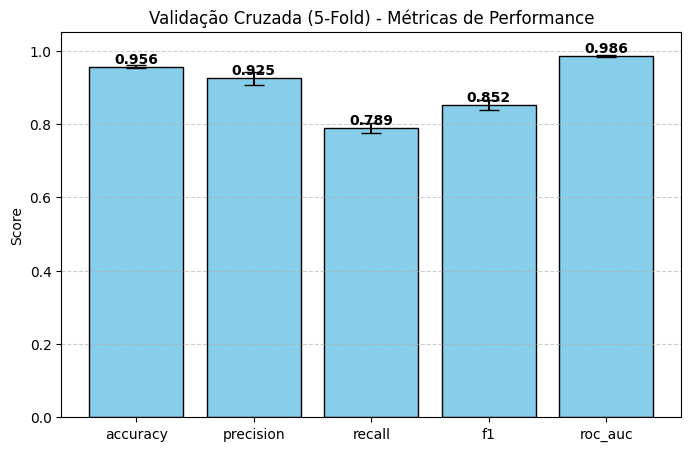

In [37]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
means = [cv_scores[f'test_{m}'].mean() for m in metrics]
stds = [cv_scores[f'test_{m}'].std() * 2 for m in metrics]  # intervalo ~95%

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, means, yerr=stds, capsize=7, color="skyblue", edgecolor="black")

# Colocar os valores em cima das barras
for bar, mean in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{mean:.3f}", ha="center", fontsize=10, fontweight="bold")

plt.title("Validação Cruzada (5-Fold) - Métricas de Performance")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


##### SIMULAÇÃO FINANCEIRA ATUALIZADA

In [38]:
print("\n SIMULAÇÃO FINANCEIRA:")
# Valores mais conservadores sem data leakage
lucro_cliente_bom = 1000  # Lucro médio por cliente bom
custo_cliente_ruim = 3000  # Perda média por inadimplente

# Com modelo
vp = np.sum((y_test == 0) & (y_pred_P == 0))  # Verdadeiros Positivos (bons aprovados)
fp = np.sum((y_test == 1) & (y_pred_P == 0))  # Falsos Positivos (ruins aprovados)
fn = np.sum((y_test == 0) & (y_pred_P == 1))  # Falsos Negativos (bons rejeitados)

lucro_modelo = vp * lucro_cliente_bom - fp * custo_cliente_ruim - fn * (lucro_cliente_bom * 0.3)

# Sem modelo (aprova todos)
total_bons = np.sum(y_test == 0)
total_ruins = np.sum(y_test == 1)
lucro_sem_modelo = total_bons * lucro_cliente_bom - total_ruins * custo_cliente_ruim

print(f"Lucro COM modelo: R$ {lucro_modelo:,.2f}")
print(f"Lucro SEM modelo: R$ {lucro_sem_modelo:,.2f}")
print(f"Ganho incremental: R$ {lucro_modelo - lucro_sem_modelo:,.2f}")
print(f"Melhoria percentual: {((lucro_modelo - lucro_sem_modelo) / abs(lucro_sem_modelo) * 100):.1f}%")


 SIMULAÇÃO FINANCEIRA:
Lucro COM modelo: R$ 4,370,200.00
Lucro SEM modelo: R$ 3,814,000.00
Ganho incremental: R$ 556,200.00
Melhoria percentual: 14.6%


##### EXPORTAR MODELO PARA PRODUÇÃO

In [39]:
# Salvar modelo e preprocessadores

# Criar pipeline completo
production_pipeline = {
    'model': best_model,
    'imputer': imputer,
    'scaler': scaler,
    'feature_names': X_train_scaled.columns.tolist(),
    'optimal_threshold': optimal_threshold,
    'encoding_maps': {}  # Adicionar mapeamentos de target encoding aqui
}

# Salvar
joblib.dump(production_pipeline, 'credit_model_production.pkl')
print("\n Modelo salvo para produção!")


 Modelo salvo para produção!


##### RECOMENDAÇÕES FINAIS

In [40]:
print("\n RECOMENDAÇÕES:")
print("1. Implementar monitoramento de drift em produção")
print("2. Retreinar o modelo mensalmente com dados atualizados")
print("3. Adicionar features externas (bureau de crédito)")
print("4. Considerar ensemble com outros algoritmos")
print("5. Implementar testes A/B antes do rollout completo")
print(f"6. Usar threshold de {optimal_threshold:.3f} em produção")
print("7. Monitorar métricas de fairness continuamente")


 RECOMENDAÇÕES:
1. Implementar monitoramento de drift em produção
2. Retreinar o modelo mensalmente com dados atualizados
3. Adicionar features externas (bureau de crédito)
4. Considerar ensemble com outros algoritmos
5. Implementar testes A/B antes do rollout completo
6. Usar threshold de 0.267 em produção
7. Monitorar métricas de fairness continuamente
